# Predicting Energy Consumption

Energy forcasting is important to the energy industry because it helps us to ensure the stability and reliability of the electrical grid. It is a unique comodity that has to be used as its being generated. It cannot be stored. If demand and supply do not balance this could cause major problems to the electrical grid and even cause system failure. 

Being able to predict demand also helps to predict market prices. This allows energy companies to make decisions about generation and bidding in the energy market.

Energy demand depends on many factors. Business and day to day activites drives our energy usage. There are peak times during the day, demand on week days and weekends are different as well as holidays. Demand is also dependent on the weather. On cold or hot days, people use more energy heating or cooling their homes. There is not only a daily pattern based on a work day or a weekend or holiday but also a seasonal pattern that impacts energy demand.

My question I want to answer with this study, is can I use daily temperature highs to predict energy consumption?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn import neighbors


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Temperature Data Set
This data set is an open data set from Kaggle that has the daily average temperatures for major cities around the world from 1995 to 2020. I wanted to start with only keeping the cities from the United States.

In [2]:
city_temps = pd.read_csv('city_temperature.csv.xz')
city_temps.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


### Get only US cities

In [3]:
US_cities = city_temps[city_temps['Country'] == 'US']
US_cities.drop(columns=['Region', 'Country'], axis = 1, inplace=True)
US_cities.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,State,City,Month,Day,Year,AvgTemperature
1450990,Alabama,Birmingham,1,1,1995,50.7
1450991,Alabama,Birmingham,1,2,1995,37.2
1450992,Alabama,Birmingham,1,3,1995,33.2
1450993,Alabama,Birmingham,1,4,1995,33.3
1450994,Alabama,Birmingham,1,5,1995,26.4


### Get only cities in PJM service territory

Next I had to figure out which cities in this data set were part of the PJM service territory. That took a bit of research but once I figured it out, I only kept the following states you see below.

In [4]:
US_region = US_cities[US_cities.State.isin(['Delaware',
          'Indiana',
          'Maryland',
          'New Jersey',
          'Ohio',
          'Pennsylvania',
          'Virginia',
          'West Virginia',
          'District of Columbia'])]

In [5]:
US_region['State'].value_counts()

Ohio                    64855
Pennsylvania            52076
Indiana                 37060
Maryland                27795
Virginia                27795
West Virginia           18530
District of Columbia    18530
New Jersey              18530
Delaware                 5751
Name: State, dtype: int64

In [6]:
US_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270922 entries, 1662774 to 2853214
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   State           270922 non-null  object 
 1   City            270922 non-null  object 
 2   Month           270922 non-null  int64  
 3   Day             270922 non-null  int64  
 4   Year            270922 non-null  int64  
 5   AvgTemperature  270922 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 14.5+ MB


In [7]:
US_region['Year'].value_counts()

1996    10980
2000    10980
2004    10980
2008    10980
2007    10950
2006    10950
1997    10950
1998    10950
1999    10950
2001    10950
2002    10950
2003    10950
2005    10950
1995    10950
2009    10950
2010    10764
2012    10248
2016    10248
2019    10220
2011    10220
2013    10220
2014    10220
2015    10220
2017    10220
2018    10220
2020     3752
Name: Year, dtype: int64

# Load Hourly Energy Consumption Data Set
Next I loaded the Dataset for hourly consumption for th PJM RTO. An RTO is a regional transmission organization that many ISOs (Independent Service Operators) are apart of to provide electricity to their service area. Having a larger interconnection helps to have a more stable system. Over the past 20 to 30 years, many ISOs and other entities have either joined or left PJM (Pennsylvania, Jersey, Maryland). Because of this I found alot of missing data. I did find a column for the eastern part of PJM and for the western part of PJM. I ultimately decided to add these two columns together to get the total consumption for the entire area.

In [8]:
energy_consump = pd.read_csv('pjm_hourly_est.csv')
energy_consump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  178262 non-null  object 
 1   AEP       121273 non-null  float64
 2   COMED     66497 non-null   float64
 3   DAYTON    121275 non-null  float64
 4   DEOK      57739 non-null   float64
 5   DOM       116189 non-null  float64
 6   DUQ       119068 non-null  float64
 7   EKPC      45334 non-null   float64
 8   FE        62874 non-null   float64
 9   NI        58450 non-null   float64
 10  PJME      145366 non-null  float64
 11  PJMW      143206 non-null  float64
 12  PJM_Load  32896 non-null   float64
dtypes: float64(12), object(1)
memory usage: 17.7+ MB


In [9]:
energy_consump

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178257,2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
178258,2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
178259,2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN
178260,2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,NaN,40164.0,7958.0,NaN


### Fill all NA with zeros
I had to do this because when I add the two columns together, if one column had an NaN in it, it would've gotten dropped from the dataset.

In [10]:
energy_consump.fillna(0, inplace=True)
energy_consump

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29309.0
1,1998-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28236.0
2,1998-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27692.0
3,1998-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27596.0
4,1998-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178257,2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,0.0,44284.0,8401.0,0.0
178258,2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,0.0,43751.0,8373.0,0.0
178259,2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,0.0,42402.0,8238.0,0.0
178260,2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,0.0,40164.0,7958.0,0.0


### Get total consumption for PJM service area

In [11]:
energy_consump['PJM'] = energy_consump['PJME'] + energy_consump['PJMW']
energy_consump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  178262 non-null  object 
 1   AEP       178262 non-null  float64
 2   COMED     178262 non-null  float64
 3   DAYTON    178262 non-null  float64
 4   DEOK      178262 non-null  float64
 5   DOM       178262 non-null  float64
 6   DUQ       178262 non-null  float64
 7   EKPC      178262 non-null  float64
 8   FE        178262 non-null  float64
 9   NI        178262 non-null  float64
 10  PJME      178262 non-null  float64
 11  PJMW      178262 non-null  float64
 12  PJM_Load  178262 non-null  float64
 13  PJM       178262 non-null  float64
dtypes: float64(13), object(1)
memory usage: 19.0+ MB


In [12]:
total_energy_consump = pd.concat([energy_consump.Datetime, energy_consump.PJM], axis=1)
total_energy_consump = total_energy_consump[total_energy_consump['PJM']>0]
total_energy_consump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145366 entries, 32896 to 178261
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJM       145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.3+ MB


### Separate Date and Time
I separated the date and time to make it match the other data set for when I merge them together.

In [13]:
total_energy_consump["Actual_datetime"] = pd.to_datetime(total_energy_consump["Datetime"])
total_energy_consump["Year"] = total_energy_consump["Actual_datetime"].dt.year
total_energy_consump["Month"] = total_energy_consump["Actual_datetime"].dt.month
total_energy_consump['Day'] = total_energy_consump['Actual_datetime'].dt.day
total_energy_consump["Date"] = total_energy_consump["Actual_datetime"].dt.date 
total_energy_consump["Time"] = total_energy_consump["Actual_datetime"].dt.time

total_energy_consump

,Datetime,PJM,Actual_datetime,Year,Month,Day,Date,Time
32896,2002-12-31 01:00:00,31575.0,2002-12-31 01:00:00,2002,12,31,2002-12-31,01:00:00
32897,2002-12-31 02:00:00,30086.0,2002-12-31 02:00:00,2002,12,31,2002-12-31,02:00:00
32898,2002-12-31 03:00:00,29459.0,2002-12-31 03:00:00,2002,12,31,2002-12-31,03:00:00
32899,2002-12-31 04:00:00,29250.0,2002-12-31 04:00:00,2002,12,31,2002-12-31,04:00:00
32900,2002-12-31 05:00:00,29790.0,2002-12-31 05:00:00,2002,12,31,2002-12-31,05:00:00
...,...,...,...,...,...,...,...,...
178257,2018-01-01 20:00:00,52685.0,2018-01-01 20:00:00,2018,1,1,2018-01-01,20:00:00
178258,2018-01-01 21:00:00,52124.0,2018-01-01 21:00:00,2018,1,1,2018-01-01,21:00:00
178259,2018-01-01 22:00:00,50640.0,2018-01-01 22:00:00,2018,1,1,2018-01-01,22:00:00
178260,2018-01-01 23:00:00,48122.0,2018-01-01 23:00:00,2018,1,1,2018-01-01,23:00:00


In [15]:
# total_energy_consump["Date"] = pd.to_datetime(total_energy_consump["Datetime"]).dt.date
# total_energy_consump['Time'] = pd.to_datetime(total_energy_consump['Datetime']).dt.time
# total_energy_consump['Year'] = pd.DatetimeIndex(total_energy_consump['Date']).year
# total_energy_consump['Month'] = pd.DatetimeIndex(total_energy_consump['Date']).month
# total_energy_consump['Day'] = pd.DatetimeIndex(total_energy_consump['Date']).day

# total_energy_consump.head()

### Get data for only 2005 or later

In [14]:
total_energy_consump_cleaned = total_energy_consump.drop(columns='Datetime', axis=1)
total_energy_consump_cleaned = total_energy_consump_cleaned[total_energy_consump['Year'] >=2005]
total_energy_consump_cleaned.head()

,PJM,Actual_datetime,Year,Month,Day,Date,Time
50435,32104.0,2005-01-01 00:00:00,2005,1,1,2005-01-01,00:00:00
59194,34115.0,2005-12-31 01:00:00,2005,12,31,2005-12-31,01:00:00
59195,32653.0,2005-12-31 02:00:00,2005,12,31,2005-12-31,02:00:00
59196,31841.0,2005-12-31 03:00:00,2005,12,31,2005-12-31,03:00:00
59197,31454.0,2005-12-31 04:00:00,2005,12,31,2005-12-31,04:00:00


In [15]:
total_energy_consump.head()

,Datetime,PJM,Actual_datetime,Year,Month,Day,Date,Time
32896,2002-12-31 01:00:00,31575.0,2002-12-31 01:00:00,2002,12,31,2002-12-31,01:00:00
32897,2002-12-31 02:00:00,30086.0,2002-12-31 02:00:00,2002,12,31,2002-12-31,02:00:00
32898,2002-12-31 03:00:00,29459.0,2002-12-31 03:00:00,2002,12,31,2002-12-31,03:00:00
32899,2002-12-31 04:00:00,29250.0,2002-12-31 04:00:00,2002,12,31,2002-12-31,04:00:00
32900,2002-12-31 05:00:00,29790.0,2002-12-31 05:00:00,2002,12,31,2002-12-31,05:00:00


In [16]:
total_energy_consump_cleaned['Year'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018])

In [17]:
US_region_cleaned = US_region[US_region['Year']>=2005]
US_region_cleaned = US_region_cleaned[US_region_cleaned['Year']<=2018]
US_region_cleaned['Year'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018])

In [18]:
US_region_cleaned['City_State']= US_region_cleaned['City'] + ', ' + US_region_cleaned['State']
US_region_cleaned.head()

,State,City,Month,Day,Year,AvgTemperature,City_State
1666427,Delaware,Wilmington,1,1,2005,57.2,"Wilmington, Delaware"
1666428,Delaware,Wilmington,1,2,2005,40.9,"Wilmington, Delaware"
1666429,Delaware,Wilmington,1,3,2005,45.0,"Wilmington, Delaware"
1666430,Delaware,Wilmington,1,4,2005,51.0,"Wilmington, Delaware"
1666431,Delaware,Wilmington,1,5,2005,42.7,"Wilmington, Delaware"


In [19]:
US_region_cleaned["City_State"].unique()

array(['Wilmington, Delaware', 'Washington, District of Columbia',
       'Washington DC, Maryland', 'Evansville, Indiana',
       'Fort Wayne, Indiana', 'Indianapolis, Indiana',
       'South Bend, Indiana', 'Baltimore, Maryland',
       'Atlantic City, New Jersey', 'Newark, New Jersey',
       'Akron Canton, Ohio', 'Cincinnati, Ohio', 'Cleveland, Ohio',
       'Columbus, Ohio', 'Dayton, Ohio', 'Toledo, Ohio',
       'Youngstown, Ohio', 'Allentown, Pennsylvania',
       'Erie, Pennsylvania', 'Harrisburg, Pennsylvania',
       'Philadelphia, Pennsylvania', 'Pittsburgh, Pennsylvania',
       'Wilkes Barre, Pennsylvania', 'Norfolk, Virginia',
       'Richmond, Virginia', 'Roanoke, Virginia',
       'Charleston, West Virginia', 'Elkins, West Virginia'], dtype=object)

### Get rid of Missing Values in Temperature Data Set
As you can see from the graph below, some of the daily average temperatures were recorded as -99.0. This is clearly not a possible reading and therefore has been recorded as such inplace of NaN. Below is my investigation and cleaning out of this erroneous data.

In [20]:
US_region_cleaned['AvgTemperature'].value_counts().sort_values(ascending = True)

-8.8       1
 0.0       1
 95.6      1
-4.2       1
-5.5       1
        ... 
 76.3    387
 75.7    391
 73.5    396
 74.8    402
 75.4    410
Name: AvgTemperature, Length: 971, dtype: int64

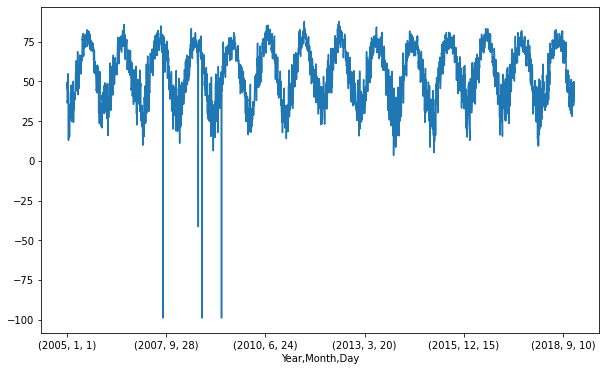

In [21]:
US_region_cleaned.groupby(['Year','Month','Day'])['AvgTemperature'].mean().plot(kind = 'line', figsize = (10,6))

In [22]:
 print(US_region_cleaned[US_region_cleaned.AvgTemperature == -99.0].count())

State             166
City              166
Month             166
Day               166
Year              166
AvgTemperature    166
City_State        166
dtype: int64


In [23]:
US_region_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147360 entries, 1666427 to 2852715
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   State           147360 non-null  object 
 1   City            147360 non-null  object 
 2   Month           147360 non-null  int64  
 3   Day             147360 non-null  int64  
 4   Year            147360 non-null  int64  
 5   AvgTemperature  147360 non-null  float64
 6   City_State      147360 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 9.0+ MB


In [24]:
US_region_cleaned['AvgTemperature'] = US_region_cleaned['AvgTemperature'].replace(-99.0, np.nan)
US_region_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147360 entries, 1666427 to 2852715
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   State           147360 non-null  object 
 1   City            147360 non-null  object 
 2   Month           147360 non-null  int64  
 3   Day             147360 non-null  int64  
 4   Year            147360 non-null  int64  
 5   AvgTemperature  147194 non-null  float64
 6   City_State      147360 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 9.0+ MB


In [25]:
US_region_cleaned.dropna(inplace=True)
US_region_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147194 entries, 1666427 to 2852715
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   State           147194 non-null  object 
 1   City            147194 non-null  object 
 2   Month           147194 non-null  int64  
 3   Day             147194 non-null  int64  
 4   Year            147194 non-null  int64  
 5   AvgTemperature  147194 non-null  float64
 6   City_State      147194 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 9.0+ MB


### Look at data
This is my exploration of the data. I organized it by year/month/day, as well as year/month, and finally just by month to get an overal yearly picture of temperature and consumption. You can see that during the hotter and colder months during the summer and winter, consumption increases. During the mild parts of the year when the average temperature is around 60-70 degrees farenheit consumption is at a low for the year.

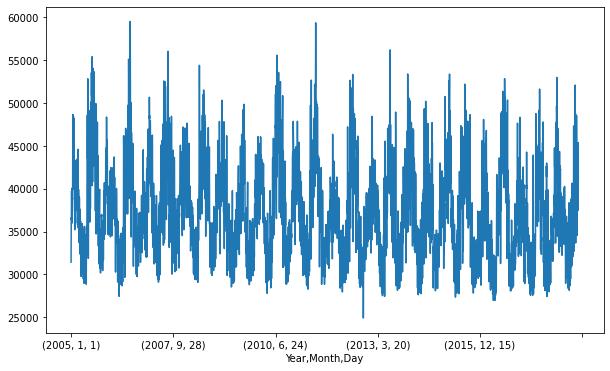

In [26]:
total_energy_consump_cleaned.groupby(['Year','Month', 'Day'])['PJM'].mean().plot(kind = 'line', figsize = (10,6))

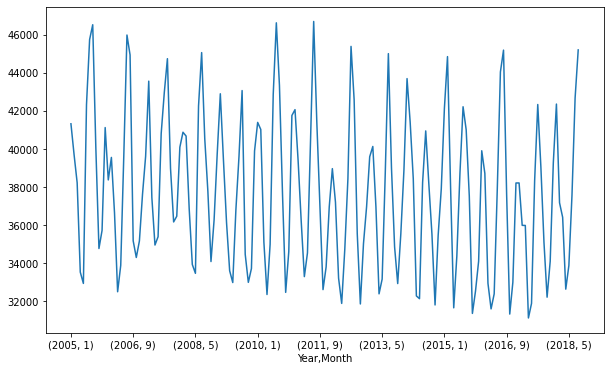

In [27]:
total_energy_consump_cleaned.groupby(['Year', 'Month'])['PJM'].mean().plot(kind = 'line', figsize = (10,6))

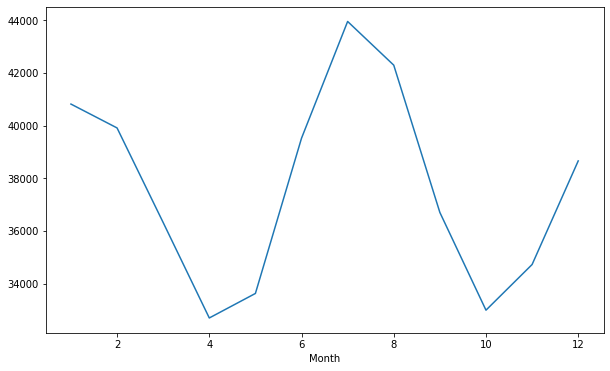

In [28]:
total_energy_consump_cleaned.groupby('Month')['PJM'].mean().plot(kind = 'line', figsize = (10,6))

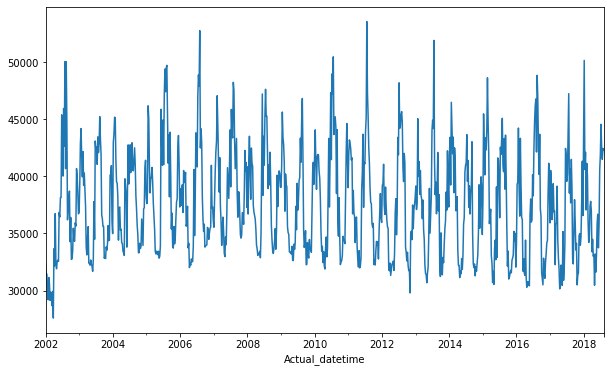

In [29]:
total_energy_consump.groupby(pd.Grouper(key='Actual_datetime', freq = 'W'))['PJM'].mean().plot(kind='line', figsize=(10,6))

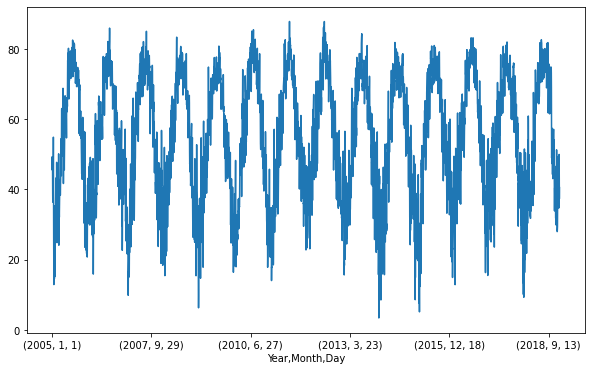

In [30]:
#plt.plot(x='Year', y='AvgTemperature', data=US_region_cleaned)
# Avg_temp_per_year_plot = US_region_cleaned.groupby(['Month','Year'])['AvgTemperature'].mean().plot(kind = 'line', figsize = (10,6))

#plt.plot(x='Year', y='AvgTemperature', data=US_region_cleaned)
US_region_cleaned.groupby(['Year','Month','Day'])['AvgTemperature'].mean().plot(kind = 'line', figsize = (10,6))

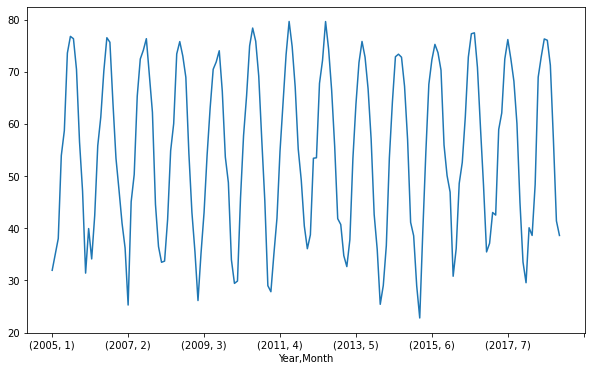

In [31]:
US_region_cleaned.groupby(['Year','Month'])['AvgTemperature'].mean().plot(kind = 'line', figsize = (10,6))

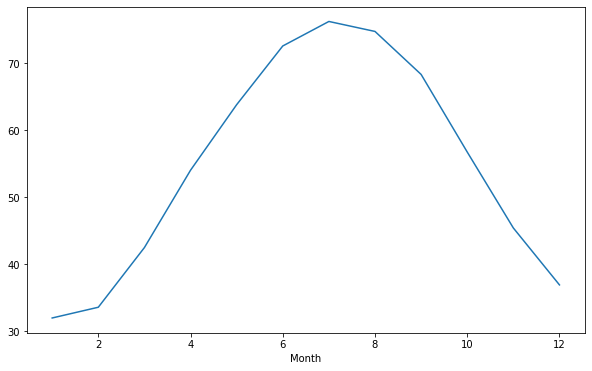

In [32]:
US_region_cleaned.groupby('Month')['AvgTemperature'].mean().plot(kind = 'line', figsize = (10,6))

In [33]:
dict_of_yearly_temperatures = {}
for year in sorted(set(US_region_cleaned.Year.unique())):
  dict_of_yearly_temperatures[year] = US_region_cleaned[US_region_cleaned['Year']==year].groupby('Month')['AvgTemperature'].mean()

In [34]:
dict_of_yearly_temperatures

{2005: Month
 1     31.936129
 2     35.019881
 3     38.026129
 4     53.927778
 5     58.710538
 6     73.574889
 7     76.774624
 8     76.325699
 9     70.440222
 10    56.542796
 11    47.116463
 12    31.398817
 Name: AvgTemperature, dtype: float64, 2006: Month
 1     39.936989
 2     34.115714
 3     42.435699
 4     55.805111
 5     61.321098
 6     70.114333
 7     76.513978
 8     75.647789
 9     64.044259
 10    53.396667
 11    47.308778
 12    40.951613
 Name: AvgTemperature, dtype: float64, 2007: Month
 1     36.222581
 2     25.280952
 3     45.083978
 4     50.291556
 5     65.316362
 6     72.434444
 7     74.102796
 8     76.332556
 9     69.352444
 10    62.228387
 11    44.584111
 12    36.496013
 Name: AvgTemperature, dtype: float64, 2008: Month
 1     33.474030
 2     33.700807
 3     41.678817
 4     54.860889
 5     60.048495
 6     73.407000
 7     75.770658
 8     72.997312
 9     68.937356
 10    54.344073
 11    43.046111
 12    35.484946
 Name: AvgTemperat

In [35]:
!pip install colorcet
import colorcet as cc

     |████████████████████████████████| 1.6MB 4.7MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 


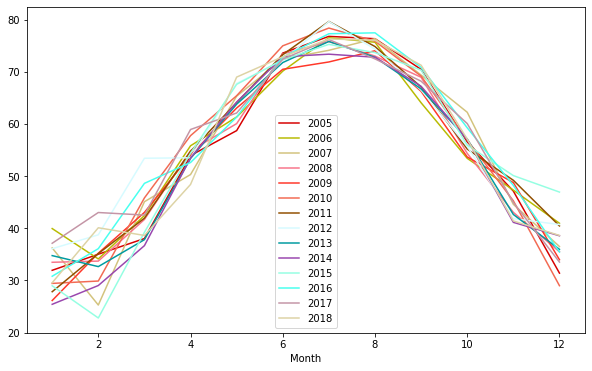

In [36]:

pd.DataFrame(dict_of_yearly_temperatures).plot(cmap=cc.cm.glasbey_light, figsize=(10,6))

In [37]:
dict_of_yearly_consumption = {}
for year in sorted(set(total_energy_consump_cleaned.Year.unique())):
  dict_of_yearly_consumption[year] = total_energy_consump_cleaned[total_energy_consump_cleaned['Year']==year].groupby('Month')['PJM'].mean()

In [38]:
dict_of_yearly_consumption

{2005: Month
 1     41324.364247
 2     39717.090774
 3     38223.375000
 4     33529.485396
 5     32936.103495
 6     42331.826389
 7     45749.513441
 8     46529.139785
 9     40063.598611
 10    34770.211306
 11    35722.112500
 12    41126.016129
 Name: PJM, dtype: float64, 2006: Month
 1     38374.450269
 2     39556.635417
 3     36644.981183
 4     32498.152990
 5     33885.607527
 6     39738.515278
 7     45987.889785
 8     44942.404570
 9     35174.338889
 10    34299.005384
 11    35166.022222
 12    37620.690860
 Name: PJM, dtype: float64, 2007: Month
 1     39618.724462
 2     43564.351190
 3     37451.130552
 4     34953.038889
 5     35390.005376
 6     40812.134722
 7     42969.143817
 8     44745.486559
 9     38978.170833
 10    36166.936828
 11    36465.522949
 12    40096.544355
 Name: PJM, dtype: float64, 2008: Month
 1     40880.275538
 2     40679.669540
 3     36850.187079
 4     33930.148611
 5     33465.760753
 6     42259.313889
 7     45065.192204
 8     

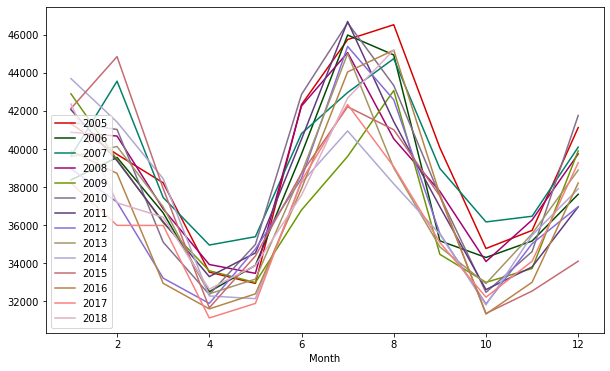

In [39]:
pd.DataFrame(dict_of_yearly_consumption).plot(cmap=cc.cm.glasbey_dark, figsize=(10,6))

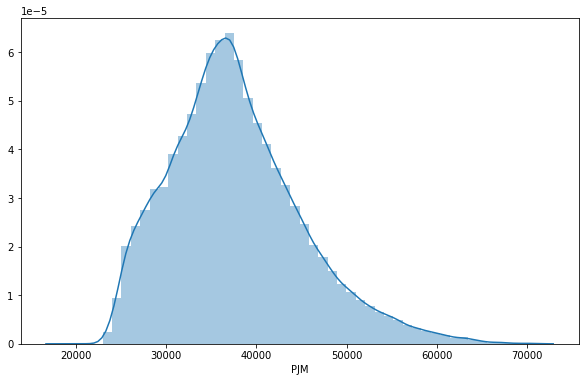

In [40]:
fig_dims = (10,6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(total_energy_consump_cleaned['PJM'], ax=ax)

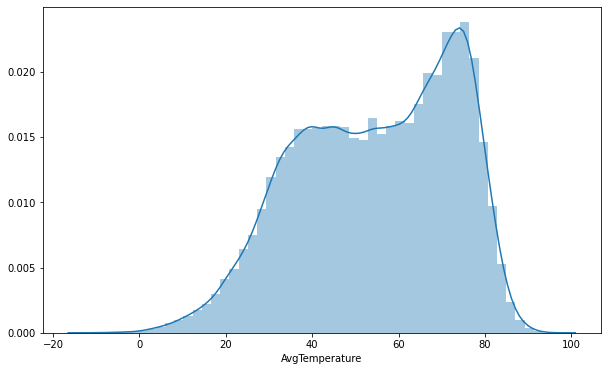

In [41]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(US_region_cleaned['AvgTemperature'], ax=ax)

In [42]:
#Get daily average temps
daily_avg_temps = US_region_cleaned.groupby(['Year','Month','Day'])['AvgTemperature'].mean()
print(daily_avg_temps)

Year  Month  Day
2005  1      1      49.283333
             2      45.526667
             3      49.160000
             4      49.180000
             5      42.033333
                      ...    
2018  12     27     38.775000
             28     49.985714
             29     43.150000
             30     37.357143
             31     40.535714
Name: AvgTemperature, Length: 5110, dtype: float64


In [43]:
daily_avg_temps.head(50)

Year  Month  Day
2005  1      1      49.283333
             2      45.526667
             3      49.160000
             4      49.180000
             5      42.033333
             6      38.913333
             7      36.406667
             8      37.916667
             9      36.970000
             10     39.530000
             11     40.473333
             12     48.480000
             13     54.886667
             14     41.913333
             15     27.333333
             16     25.596667
             17     18.800000
             18     12.940000
             19     20.316667
             20     26.786667
             21     20.520000
             22     17.703333
             23     14.683333
             24     14.733333
             25     28.496667
             26     35.326667
             27     19.793333
             28     15.280000
             29     23.936667
             30     30.056667
             31     27.043333
      2      1      26.916667
             2      27.

In [44]:
#get daily average consumption
daily_avg_consump = total_energy_consump_cleaned.groupby(['Year','Month','Day'])['PJM'].mean()
daily_avg_consump.head(50)

Year  Month  Day
2005  1      1      31432.708333
             2      33963.958333
             3      36609.375000
             4      36429.375000
             5      38719.666667
             6      39743.500000
             7      38976.750000
             8      36794.708333
             9      35978.416667
             10     39163.333333
             11     40079.416667
             12     39018.208333
             13     37290.708333
             14     37665.416667
             15     38852.583333
             16     38805.625000
             17     44604.708333
             18     48570.458333
             19     48667.625000
             20     44678.750000
             21     46153.958333
             22     46378.083333
             23     44169.458333
             24     48464.458333
             25     45136.041667
             26     42845.750000
             27     47110.375000
             28     48206.875000
             29     43321.500000
             30     39950.

In [45]:
model_data = pd.merge(daily_avg_temps,daily_avg_consump,on=['Year', 'Month', 'Day'])
model_data.head(50)

AvgTemperature           PJM
Year Month Day                              
2005 1     1         49.283333  31432.708333
           2         45.526667  33963.958333
           3         49.160000  36609.375000
           4         49.180000  36429.375000
           5         42.033333  38719.666667
           6         38.913333  39743.500000
           7         36.406667  38976.750000
           8         37.916667  36794.708333
           9         36.970000  35978.416667
           10        39.530000  39163.333333
           11        40.473333  40079.416667
           12        48.480000  39018.208333
           13        54.886667  37290.708333
           14        41.913333  37665.416667
           15        27.333333  38852.583333
           16        25.596667  38805.625000
           17        18.800000  44604.708333
           18        12.940000  48570.458333
           19        20.316667  48667.625000
           20        26.786667  44678.750000
           21        20.520000  46153.958333
           22        17.703333  46378.083333
           23        14.683333  44169.458333
           24        14.733333  48464.458333
           25        28.496667  45136.041667
           26        35.326667  42845.750000
           27        19.793333  47110.375000
           28        15.280000  48206.875000
           29        23.936667  43321.500000
           30        30.056667  39950.708333
           31        27.043333  43272.791667
     2     1         26.916667  43601.750000
           2         27.163333  43247.875000
           3         31.606667  42723.541667
           4         33.773333  40597.125000
           5         37.623333  36523.583333
           6         40.020000  35221.541667
           7         42.696667  38450.458333
           8         43.283333  38267.250000
           9         42.086667  37561.750000
           10        35.560000  39625.875000
           11        28.490000  41921.541667
           12        35.746667  38031.875000
           13        37.410000  35998.708333
           14        42.270000  40377.000000
           15        47.730000  37443.750000
           16        43.790000  38016.125000
           17        33.350000  40644.291667
           18        25.793333  43301.416667
           19        24.866667  40774.291667

In [46]:
model_data.shape

(4960, 2)

Below is a very interesting graph. It shows that temperature and consumption are somewhat linear but it has an inverse relationship for when the temperature is low(below 65) and a direct relationship when the temperature is higher (above 65). We also see the slope is greater for the higher temperatures than for the lower temperatures. Because of this, I decided to try a linear regression model but because it had two different relationships depending on the temperature range, I decided to split it into two different models halves, one for below 65 degrees and one for above 65 degrees.

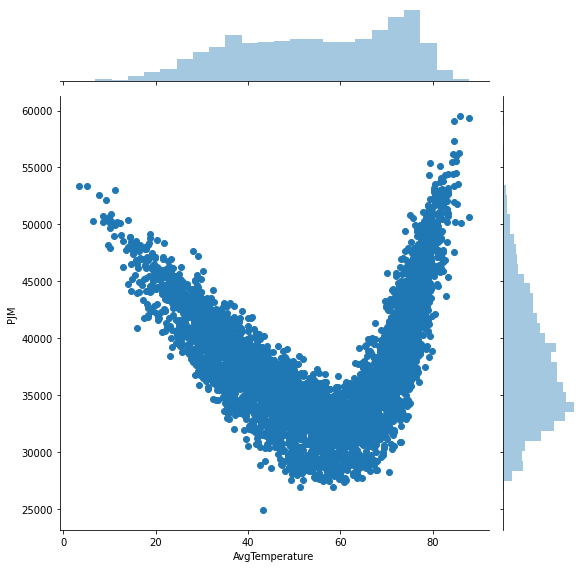

In [47]:
sns.jointplot(x='AvgTemperature', y='PJM', data = model_data, height=8)

In [48]:
stats.pearsonr(model_data['AvgTemperature'],model_data['PJM'])

(0.061710203214764746, 1.3667818391766261e-05)

In [49]:
model_data_under_65 = model_data[model_data['AvgTemperature'] <= 65]
stats.pearsonr(model_data_under_65['AvgTemperature'],model_data_under_65['PJM'])


(-0.8412984910164135, 0.0)

# Cold Linear Regression Model (below 65 degrees)

In [50]:
X_Cold = model_data_under_65.drop(columns=['PJM'])
y_cold = model_data_under_65.PJM
XC_train, XC_test, yc_train, yc_test = train_test_split(X_Cold, y_cold, random_state = 22)
lrm = linear_model.LinearRegression()
lrm__cold_results = lrm.fit(XC_train,yc_train)
print(lrm.score(XC_train,yc_train))
print(lrm.score(XC_test, yc_test))

0.7038508986641808
0.7183706263525713


In [51]:
XC_train_w_constant = sm.add_constant(XC_train)
Cold_OLS_results = sm.OLS(yc_train,XC_train_w_constant).fit()
print(Cold_OLS_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PJM   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     5673.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:49:07   Log-Likelihood:                -22037.
No. Observations:                2389   AIC:                         4.408e+04
Df Residuals:                    2387   BIC:                         4.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.938e+04    183.502    269.

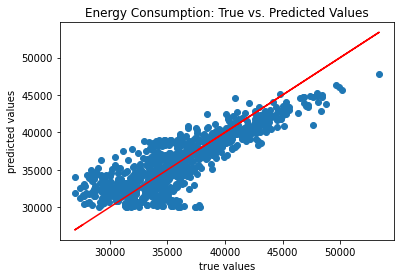

Mean absolute error of the prediction is: 1977.6336381508002
Mean squared error of the prediction is: 6141674.312643219
Root mean squared error of the prediction is: 2478.2401644399233
Mean absolute percentage error of the prediction is: 5.644809201534053


In [52]:
XC_test_w_constant = sm.add_constant(XC_test)
yc_pred = Cold_OLS_results.predict(XC_test_w_constant)

plt.scatter(yc_test, yc_pred)
plt.plot(yc_test, yc_test, color = 'red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Energy Consumption: True vs. Predicted Values')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yc_test, yc_pred)))
print("Mean squared error of the prediction is: {}".format(mse(yc_test, yc_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(yc_test, yc_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yc_test - yc_pred) / yc_test)) * 100))


## Cold Linear Regression Adjusted Model
(the adjusted model uses not just the temperature but the squares of the temperature too)

In [53]:
model_data['AvgTemperatureSquared'] = model_data["AvgTemperature"]**2
model_data['PJM_logged'] = np.log(model_data["PJM"])
model_data['AvgTemperature'].corr(model_data['PJM_logged'])

0.04355987922878146

In [54]:
model_data['AvgTemperatureSquared'].corr(model_data['PJM'])

0.19344083475566856

In [56]:
adjusted_model_cold = model_data[model_data['AvgTemperature'] <= 65]
X_Cold_adj = adjusted_model_cold.drop(columns=['PJM','PJM_logged'])
y_cold_adj = adjusted_model_cold.PJM
XCA_train, XCA_test, yca_train, yca_test = train_test_split(X_Cold_adj, y_cold_adj, random_state = 22)
lrm = linear_model.LinearRegression()
lrm_cold_adj_results = lrm.fit(XCA_train,yca_train)
print(lrm.score(XCA_train,yca_train))
print(lrm.score(XCA_test, yca_test))


0.7578294661998509
0.7626681509939909


In [57]:
XCA_train_w_constant = sm.add_constant(XCA_train)
Cold_adj_OLS_results = sm.OLS(yca_train,XCA_train_w_constant).fit()
print(Cold_adj_OLS_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PJM   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     3733.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:49:30   Log-Likelihood:                -21797.
No. Observations:                2389   AIC:                         4.360e+04
Df Residuals:                    2386   BIC:                         4.362e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.888e+

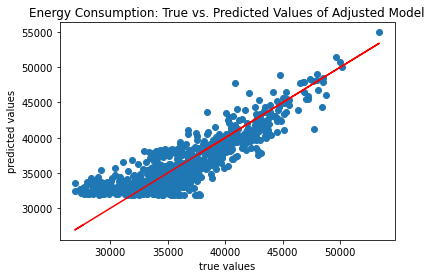

Mean absolute error of the prediction is: 1819.201992441605
Mean squared error of the prediction is: 5175649.477661038
Root mean squared error of the prediction is: 2275.005379699362
Mean absolute percentage error of the prediction is: 5.224310119653671


In [58]:
XCA_test_w_constant = sm.add_constant(XCA_test)
yca_pred = Cold_adj_OLS_results.predict(XCA_test_w_constant)

plt.scatter(yca_test, yca_pred)
plt.plot(yca_test, yca_test, color = 'red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Energy Consumption: True vs. Predicted Values of Adjusted Model')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yca_test, yca_pred)))
print("Mean squared error of the prediction is: {}".format(mse(yca_test, yca_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(yca_test, yca_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yca_test - yca_pred) / yca_test)) * 100))


## Cold Ridge Regression Model

In [59]:
ridgeregr = RidgeCV(alphas=(10**2,10**4,10**6))
ridgeregr.fit(XCA_train,yca_train)

yca_pred_train = ridgeregr.predict(XCA_train)
yca_pred_test = ridgeregr.predict(XCA_test)

print("The best alpha is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(XCA_train, yca_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(XCA_test, yca_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yca_test, yca_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yca_test, yca_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yca_test, yca_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yca_test - yca_pred_test) / yca_test)) * 100))


The best alpha is: 100
R-squared of the model on the training set is: 0.757817515580731
-----Test set statistics-----
R-squared of the model on the test set is: 0.7626712391218566
Mean absolute error of the prediction is: 1818.2785720656007
Mean squared error of the prediction is: 5175582.132854862
Root mean squared error of the prediction is: 2274.990578629912
Mean absolute percentage error of the prediction is: 5.222388800372009


## Cold Lasso Regression Model

In [60]:
lassoregr = LassoCV(alphas=(10**2,10**5,10**10))
lassoregr.fit(XCA_train,yca_train)

yca_pred_train = lassoregr.predict(XCA_train)
yca_pred_test = lassoregr.predict(XCA_test)

print("The best alpha is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(XCA_train, yca_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(XCA_test, yca_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yca_test, yca_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yca_test, yca_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yca_test, yca_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yca_test - yca_pred_test) / yca_test)) * 100))


The best alpha is: 100
R-squared of the model on the training set is: 0.7577089724255712
-----Test set statistics-----
R-squared of the model on the test set is: 0.762605936945562
Mean absolute error of the prediction is: 1816.646263051788
Mean squared error of the prediction is: 5177006.21974436
Root mean squared error of the prediction is: 2275.3035445285886
Mean absolute percentage error of the prediction is: 5.2191256450535874


## Cold ElasticNet Regression Model

In [61]:
elasticregr = ElasticNetCV(alphas=(10**5,10**10,10**20))
elasticregr.fit(XCA_train,yca_train)

yca_pred_train = elasticregr.predict(XCA_train)
yca_pred_test = elasticregr.predict(XCA_test)

print("The best alpha is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(XCA_train, yca_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(XCA_test, yca_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yca_test, yca_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yca_test, yca_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yca_test, yca_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yca_test - yca_pred_test) / yca_test)) * 100))


The best alpha is: 100000
R-squared of the model on the training set is: 0.6203947024111417
-----Test set statistics-----
R-squared of the model on the test set is: 0.6394196936713594
Mean absolute error of the prediction is: 2212.4197142549788
Mean squared error of the prediction is: 7863408.480239165
Root mean squared error of the prediction is: 2804.176970206974
Mean absolute percentage error of the prediction is: 6.23488474632314


# Hot Linear Regression Model

In [62]:
model_data_over_65 = model_data[model_data['AvgTemperature'] > 65]
stats.pearsonr(model_data_over_65['AvgTemperature'],model_data_over_65['PJM'])

(0.840366924139949, 0.0)

In [63]:
X_Hot = model_data_over_65.drop(columns=['PJM'])
y_hot = model_data_over_65.PJM
XH_train, XH_test, yh_train, yh_test = train_test_split(X_Hot, y_hot, random_state = 22)
lrm = linear_model.LinearRegression()
lrm_hot_results = lrm.fit(XH_train,yh_train)
print(lrm.score(XH_train,yh_train))
print(lrm.score(XH_test, yh_test))

0.9960409826697046
0.9963131755469076


In [64]:
XH_train_w_constant = sm.add_constant(XH_train)
Hot_OLS_results = sm.OLS(yh_train,XH_train_w_constant).fit()
print(Hot_OLS_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PJM   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.112e+05
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:50:00   Log-Likelihood:                -9666.2
No. Observations:                1330   AIC:                         1.934e+04
Df Residuals:                    1326   BIC:                         1.936e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.127e+

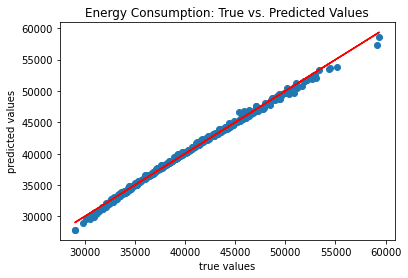

Mean absolute error of the prediction is: 252.43875203621056
Mean squared error of the prediction is: 119440.9028790593
Root mean squared error of the prediction is: 345.60223216735636
Mean absolute percentage error of the prediction is: 0.6267144808393426


In [65]:
XH_test_w_constant = sm.add_constant(XH_test)
yh_pred = Hot_OLS_results.predict(XH_test_w_constant)

plt.scatter(yh_test, yh_pred)
plt.plot(yh_test, yh_test, color = 'red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Energy Consumption: True vs. Predicted Values')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yh_test, yh_pred)))
print("Mean squared error of the prediction is: {}".format(mse(yh_test, yh_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(yh_test, yh_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yh_test - yh_pred) / yh_test)) * 100))


## Hot Linear Regression Adjusted Model

In [66]:
adjusted_model_hot = model_data[model_data['AvgTemperature'] > 65]
X_Hot_adj = adjusted_model_hot.drop(columns=['PJM','PJM_logged'])
y_hot_adj = adjusted_model_hot.PJM
XHA_train, XHA_test, yha_train, yha_test = train_test_split(X_Hot_adj, y_hot_adj, random_state = 22)
lrm = linear_model.LinearRegression()
lrm_hot_adj_results = lrm.fit(XHA_train,yha_train)
print(lrm.score(XHA_train,yha_train))
print(lrm.score(XHA_test, yha_test))

0.7152227473521614
0.7078167095815298


In [67]:
XHA_train_w_constant = sm.add_constant(XHA_train)
Hot_adj_OLS_results = sm.OLS(yha_train,XHA_train_w_constant).fit()
print(Hot_adj_OLS_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PJM   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1666.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:50:10   Log-Likelihood:                -12510.
No. Observations:                1330   AIC:                         2.503e+04
Df Residuals:                    1327   BIC:                         2.504e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.123e+

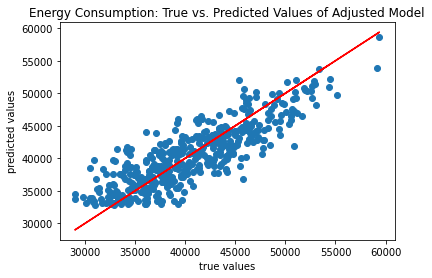

Mean absolute error of the prediction is: 2483.427778776074
Mean squared error of the prediction is: 9465771.006395828
Root mean squared error of the prediction is: 3076.649314822186
Mean absolute percentage error of the prediction is: 6.239775630465302


In [68]:
XHA_test_w_constant = sm.add_constant(XHA_test)
yha_pred = Hot_adj_OLS_results.predict(XHA_test_w_constant)

plt.scatter(yha_test, yha_pred)
plt.plot(yha_test, yha_test, color = 'red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Energy Consumption: True vs. Predicted Values of Adjusted Model')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yha_test, yha_pred)))
print("Mean squared error of the prediction is: {}".format(mse(yha_test, yha_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(yha_test, yha_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yha_test - yha_pred) / yha_test)) * 100))


## Hot Ridge Regression Model (with Adjusted)

In [69]:
ridgeregr = RidgeCV(alphas=(10**2,10**4,10**6))
ridgeregr.fit(XHA_train,yha_train)

yha_pred_train = ridgeregr.predict(XHA_train)
yha_pred_test = ridgeregr.predict(XHA_test)

print("The best alpha is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(XHA_train, yha_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(XHA_test, yha_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yha_test, yha_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yha_test, yha_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yha_test, yha_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yha_test - yha_pred_test) / yha_test)) * 100))


The best alpha is: 100
R-squared of the model on the training set is: 0.7140276315012793
-----Test set statistics-----
R-squared of the model on the test set is: 0.70447910505164
Mean absolute error of the prediction is: 2496.7570581951145
Mean squared error of the prediction is: 9573898.340251356
Root mean squared error of the prediction is: 3094.1716727181374
Mean absolute percentage error of the prediction is: 6.270935445053466


## Hot Ridge Regression Model (original data)

In [70]:
ridgeregr = RidgeCV(alphas=(10**2,10**4,10**6))
ridgeregr.fit(XH_train,yh_train)

yh_pred_train = ridgeregr.predict(XH_train)
yh_pred_test = ridgeregr.predict(XH_test)

print("The best alpha is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(XH_train, yha_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(XH_test, yha_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yh_test, yh_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yh_test, yh_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yh_test, yh_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yh_test - yh_pred_test) / yh_test)) * 100))

The best alpha is: 100
R-squared of the model on the training set is: 0.7511147377699623
-----Test set statistics-----
R-squared of the model on the test set is: 0.7425304351360282
Mean absolute error of the prediction is: 2330.4678538187845
Mean squared error of the prediction is: 8341161.257471
Root mean squared error of the prediction is: 2888.1068639285145
Mean absolute percentage error of the prediction is: 5.847263318247674


## Hot Lasso Regression Model

In [71]:
lassoregr = LassoCV(alphas=(10**2,10**5,10**10))
lassoregr.fit(XHA_train,yha_train)

yha_pred_train = lassoregr.predict(XHA_train)
yha_pred_test = lassoregr.predict(XHA_test)

print("The best alpha is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(XHA_train, yha_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(XHA_test, yha_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yha_test, yha_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yha_test, yha_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yha_test, yha_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yha_test - yha_pred_test) / yha_test)) * 100))

The best alpha is: 100
R-squared of the model on the training set is: 0.7130891598125745
-----Test set statistics-----
R-squared of the model on the test set is: 0.7027682072823238
Mean absolute error of the prediction is: 2504.66278628053
Mean squared error of the prediction is: 9629325.762115583
Root mean squared error of the prediction is: 3103.1154928741507
Mean absolute percentage error of the prediction is: 6.290911113036173


## Hot Lasso Regression Model (Original data)

In [72]:
lassoregr = LassoCV(alphas=(10**2,10**5,10**10))
lassoregr.fit(XH_train,yh_train)

yh_pred_train = lassoregr.predict(XH_train)
yh_pred_test = lassoregr.predict(XH_test)

print("The best alpha is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(XH_train, yh_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(XH_test, yh_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yh_test, yh_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yh_test, yh_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yh_test, yh_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yh_test - yh_pred_test) / yh_test)) * 100))

The best alpha is: 100
R-squared of the model on the training set is: 0.9339020715685632
-----Test set statistics-----
R-squared of the model on the test set is: 0.9302475516543735
Mean absolute error of the prediction is: 1203.5065893167837
Mean squared error of the prediction is: 2259748.332047234
Root mean squared error of the prediction is: 1503.2459319909146
Mean absolute percentage error of the prediction is: 2.9758111985181825


## Hot Elastic Net Regression Model

In [73]:
elasticregr = ElasticNetCV(alphas=(10**5,10**10,10**20))
elasticregr.fit(XHA_train,yha_train)

yha_pred_train = elasticregr.predict(XHA_train)
yha_pred_test = elasticregr.predict(XHA_test)

print("The best alpha is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(XHA_train, yha_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(XHA_test, yha_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yha_test, yha_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yha_test, yha_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yha_test, yha_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yha_test - yha_pred_test) / yha_test)) * 100))

The best alpha is: 100000
R-squared of the model on the training set is: 0.7031220333135173
-----Test set statistics-----
R-squared of the model on the test set is: 0.6948937215372597
Mean absolute error of the prediction is: 2545.938193885278
Mean squared error of the prediction is: 9884433.022866722
Root mean squared error of the prediction is: 3143.9518162444415
Mean absolute percentage error of the prediction is: 6.379894054101422


## Hot Elastic Net Regression Model (original Data)

In [74]:
elasticregr = ElasticNetCV(alphas=(10**5,10**10,10**20))
elasticregr.fit(XH_train,yh_train)

yh_pred_train = elasticregr.predict(XH_train)
yh_pred_test = elasticregr.predict(XH_test)

print("The best alpha is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(XH_train, yh_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(XH_test, yh_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yh_test, yh_pred_test)))
print("Mean squared error of the prediction is: {}".format(mse(yh_test, yh_pred_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yh_test, yh_pred_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yh_test - yh_pred_test) / yh_test)) * 100))

The best alpha is: 100000
R-squared of the model on the training set is: 0.7031220333135173
-----Test set statistics-----
R-squared of the model on the test set is: 0.6948937215372597
Mean absolute error of the prediction is: 2545.938193885278
Mean squared error of the prediction is: 9884433.022866722
Root mean squared error of the prediction is: 3143.9518162444415
Mean absolute percentage error of the prediction is: 6.379894054101422


# Overall Linear Regression Model

In [75]:
X=model_data.drop(columns=['PJM', 'PJM_logged'])
y=model_data.PJM
#first due a model with all data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 27)
lrm = linear_model.LinearRegression()
lrm_results = lrm.fit(X_train, y_train)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-1526.492281      14.84868183]

Intercept: 
 72253.68599034176


In [76]:
lrm_predictions = lrm.predict(X_test)
errors = y_test - lrm_predictions
print("Mean of the errors in the model is: {}".format(np.mean(errors)))

Mean of the errors in the model is: 23.04058566919477


In [77]:
lrm.score(X_train, y_train)

0.6847733017099773

In [78]:
lrm.score(X_test, y_test)

0.6655027500470341

# Random Forest Model

In addition to the linear regression models, I wanted to try some other models that had a little less structure like Random Forests, KNN, and Gradient Boost.

In [79]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(n_estimators=1500, max_depth=4)

tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))

print(tree.score(X_test, y_test))

0.7811654773835284
0.7480421741781651


In [97]:
from sklearn.model_selection import GridSearchCV

params = {
    "criterion" : ["mse", "mae"],
    "n_estimators" : [1000, 1500, 2000],
    "max_depth" : [2,3,4,None]
}

forest_for_gs = RandomForestRegressor()

forest_gs = GridSearchCV(forest_for_gs, params, verbose = 1, refit = True)
forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 98.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [80]:
print(forest_gs.score(X_train, y_train))
print(forest_gs.score(X_test, y_test))

NameError: ignored

# Gradient Boost Regression Model

In [81]:
from sklearn.ensemble import GradientBoostingRegressor

should_be_good = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01)

should_be_good.fit(X_train, y_train)

print(should_be_good.score(X_train, y_train))

print(should_be_good.score(X_test, y_test))

0.8171241086195189
0.7626911463810693


In [98]:
params_gb = {
    "n_estimators":[500,1000,1500,2000],
    'learning_rate':[0.01,0.1,0.5],
    'criterion' : ['friedman_mse', 'mse', 'mae']
}
  
gb_for_gs = GradientBoostingRegressor()

gb_gs = GridSearchCV(gb_for_gs, params_gb, verbose = 1, refit = True)
gb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 186.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...,
                           

In [101]:
print(gb_gs.score(X_train, y_train))
print(gb_gs.score(X_test, y_test))

0.7997908204938259
0.7668631281548688


# KNN Regression Model

In [82]:
X_train.iloc[:3000]

AvgTemperature  AvgTemperatureSquared
Year Month Day                                       
2018 2     13        30.400000             924.160000
2013 9     11        80.953571            6553.480727
2006 4     2         54.003333            2916.360011
     6     21        74.020000            5478.960400
2007 10    26        57.120000            3262.694400
...                        ...                    ...
2016 2     10        25.853571             668.407156
2017 6     13        80.757143            6521.716122
2012 1     19        27.432143             752.522462
2007 5     30        73.450000            5394.902500
2018 7     8         71.450000            5105.102500

[3000 rows x 2 columns]

In [83]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.iloc[:3000], y_train.iloc[:3000])
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.8112845107325829
0.7386288242309018


In [84]:
from sklearn.model_selection import GridSearchCV

params_knn = {
    "n_neighbors" : [3,5,7,8,10,11,99],
    'weights': ['uniform', 'distance']
}
 
knn_for_gs = KNeighborsRegressor()
knn_gs = GridSearchCV(knn_for_gs, params_knn, verbose = 1, refit = True)
knn_gs.fit(X_train, y_train)



Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 8, 10, 11, 99],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [85]:
print(knn_gs.score(X_train, y_train))
print(knn_gs.score(X_test, y_test))

0.7871741415512686
0.7631267922033351


In [86]:
pd.DataFrame(knn_gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.003378,0.000926,0.011027,0.000633,99,uniform,"{'n_neighbors': 99, 'weights': 'uniform'}",0.796535,0.768777,0.777527,0.765010,0.786462,0.778862,0.011536,1
10,0.002927,0.000181,0.003139,0.000113,11,uniform,"{'n_neighbors': 11, 'weights': 'uniform'}",0.779774,0.755155,0.767051,0.747645,0.770228,0.763971,0.011337,2
8,0.002964,0.000142,0.003037,0.000022,10,uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",0.778614,0.753969,0.766376,0.746068,0.767985,0.762602,0.011380,3
6,0.003408,0.000644,0.003592,0.000770,8,uniform,"{'n_neighbors': 8, 'weights': 'uniform'}",0.775391,0.750333,0.758349,0.737009,0.760608,0.756338,0.012609,4
4,0.003090,0.000193,0.002982,0.000265,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.769514,0.743756,0.753693,0.732888,0.756505,0.751271,0.012333,5
2,0.002871,0.000093,0.002643,0.000032,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.758116,0.725125,0.741689,0.718746,0.749612,0.738658,0.014747,6
13,0.003170,0.000309,0.011222,0.000559,99,distance,"{'n_neighbors': 99, 'weights': 'distance'}",0.764924,0.711419,0.736971,0.714261,0.755808,0.736677,0.021468,7
11,0.002922,0.000235,0.003391,0.000338,11,distance,"{'n_neighbors': 11, 'weights': 'distance'}",0.740657,0.689075,0.714658,0.686022,0.736635,0.713409,0.022916,8
9,0.002881,0.000112,0.003156,0.000030,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",0.739093,0.687386,0.713261,0.684018,0.734845,0.711721,0.023004,9
0,0.003619,0.000968,0.003059,0.000893,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.732435,0.700216,0.712990,0.671115,0.726199,0.708591,0.021783,10


Either the Gradient boost or the KNN models are the best because they have the best score results.

Random Forest is a better model because it is more resistant to variations in the data, and has better explainability.



Below here is where I was investigating different things with my mentor including how to explain and justify which model is the best.

In [88]:
!pip install eli5

     |████████████████████████████████| 112kB 5.3MB/s 


In [89]:
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [91]:
eli5.explain_weights(should_be_good)

Weight,Feature
0.5238 ± 0.5131,x1
0.4762 ± 0.5131,x0


In [92]:
eli5.explain_prediction(should_be_good, X_test.iloc[0])

Explanation(estimator="GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',\n                          init=None, learning_rate=0.01, loss='ls', max_depth=3,\n                          max_features=None, max_leaf_nodes=None,\n                          min_impurity_decrease=0.0, min_impurity_split=None,\n                          min_samples_leaf=1, min_samples_split=2,\n                          min_weight_fraction_leaf=0.0, n_estimators=2000,\n                          n_iter_no_change=None, presort='deprecated',\n                          random_state=None, subsample=1.0, tol=0.0001,\n                          validation_fraction=0.1, verbose=0, warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=37734.30910018312, std=None, value=1.0)], neg=[FeatureWeight(feature='AvgTemperatureSquared', weight=-3078.3382358654626, std=None, value=3353.5680999999995), FeatureWeight(feature='AvgTemperature', weight=-2977.737502994213, std=None, value=57.91)], pos_remaining=0, neg_remaining=0), proba=None, score=31678.233361323488, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [94]:
just_normal_temp = GradientBoostingRegressor()

just_normal_temp.fit(X_train[['AvgTemperature']], y_train)

print(just_normal_temp.score(X_train[['AvgTemperature']], y_train))
print(just_normal_temp.score(X_test[['AvgTemperature']], y_test))



0.8056939098553713
0.7661608952193943


In [95]:
eli5.explain_weights(just_normal_temp)

Weight,Feature
1.0000 ± 0.0000,x0


In [102]:
eli5.explain_prediction(just_normal_temp, X_train[['AvgTemperature']].iloc[100])

Explanation(estimator="GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',\n                          init=None, learning_rate=0.1, loss='ls', max_depth=3,\n                          max_features=None, max_leaf_nodes=None,\n                          min_impurity_decrease=0.0, min_impurity_split=None,\n                          min_samples_leaf=1, min_samples_split=2,\n                          min_weight_fraction_leaf=0.0, n_estimators=100,\n                          n_iter_no_change=None, presort='deprecated',\n                          random_state=None, subsample=1.0, tol=0.0001,\n                          validation_fraction=0.1, verbose=0, warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=37734.309100183105, std=None, value=1.0)], neg=[FeatureWeight(feature='AvgTemperature', weight=-1321.8622079599106, std=None, value=70.04285714285714)], pos_remaining=0, neg_remaining=0), proba=None, score=36412.44689222319, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [99]:
X_train[['AvgTemperature']].shape

(3720, 1)

In [103]:
eli5.explain_weights(knn)

Explanation(estimator="KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',\n                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,\n                    weights='uniform')", description=None, error="estimator KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',\n                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,\n                    weights='uniform') is not supported", method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [111]:
X_train['random_noise'] = np.random.rand(X_train.shape[0])
X_test['random_noise'] = np.random.rand(X_test.shape[0])

X_train['zeros'] = np.zeros(X_train.shape[0])
X_test['zeros'] = np.zeros(X_test.shape[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
gb_with_noise = GradientBoostingRegressor()

gb_with_noise.fit(X_train_scaled, y_train)
print(gb_with_noise.score(X_train_scaled, y_train))
print(gb_with_noise.score(X_test_scaled, y_test))

0.810845613728861
0.7641194356226335


In [121]:
knn_with_noise = KNeighborsRegressor(n_neighbors=3)
knn_with_noise.fit(X_train_scaled, y_train)
print(knn_with_noise.score(X_train_scaled, y_train))
print(knn_with_noise.score(X_test_scaled, y_test))

0.853784747657672
0.7155204773465484


In [118]:
eli5.explain_weights(gb_with_noise)

Weight,Feature
0.5611 ± 0.5615,x1
0.4294 ± 0.5419,x0
0.0096 ± 0.6834,x2
0 ± 0.0000,x3
